In [2]:
#Data


import os
# from PIL import Image
import numpy as np
import cv2

forg_dir = './Data/full_forg'
org_dir = './Data/full_org'

# Function to load images and assign categorical labels (1 for forged, 0 for original)
# Function to load images and assign categorical labels (1 for forged, 0 for original)
def load_images_with_labels_from_folder(folder, label, target_size=(224, 224), apply_noise_removal=True, apply_canny=True):
    images = []
    labels = []
    for filename in os.listdir(folder):
        if filename != "Thumbs.db":
            filepath = os.path.join(folder, filename)
            image = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
            image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

            if image is not None:
                if apply_noise_removal:
                    image = cv2.GaussianBlur(image, (5, 5), 0)
                image = cv2.resize(image, target_size)
                if apply_canny:
                    # Apply Canny edge detection
                    edges = cv2.Canny(image, 20, 100)  # You can adjust the thresholds (100 and 200) as needed
                    images.append(edges)
                else:
                    images.append(image)
                labels.append(label)
    return images, labels


# Load forged images and assign label 1
forg_images, forg_labels = load_images_with_labels_from_folder(forg_dir, 1, apply_noise_removal=False,apply_canny=False)

# Load original images and assign label 0
org_images, org_labels = load_images_with_labels_from_folder(org_dir, 0, apply_noise_removal=False,apply_canny=False)


org_images = np.array(org_images)/255.0
org_labels = np.array(org_labels)

forg_images = np.array(forg_images)/255.0
forg_labels = np.array(forg_labels)

from tensorflow.keras.utils import to_categorical
num_classes = 2  # Assuming it's a binary classification task

# Manually convert training labels to categorical form
org_labels = to_categorical(org_labels, num_classes=num_classes)
forg_labels = to_categorical(forg_labels, num_classes=num_classes)

all_images = np.concatenate((org_images, forg_images), axis=0)
all_labels = np.concatenate((org_labels, forg_labels), axis=0)

from sklearn.utils import shuffle
# Shuffle original images and labels
# all_images, all_labels = shuffle(all_images, all_labels, random_state=42)




2024-06-15 17:43:49.029549: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-15 17:43:49.029593: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-15 17:43:49.059295: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-15 17:43:49.129977: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-15 17:43:49.871570: W tensorflow/compiler/tf2

In [8]:
print(all_images.shape) 
print(org_images.shape)

(2640, 224, 224, 3)
(1320, 224, 224, 3)


In [3]:
#Heatmap Functions

from tensorflow.keras.models import Model
import tensorflow as tf
import numpy as np
import cv2

class GradCAM:
    def __init__(self, model, classIdx, layerName=None):
        # store the model, the class index used to measure the class
        # activation map, and the layer to be used when visualizing
        # the class activation map
        self.model = model
        self.classIdx = classIdx
        self.layerName = layerName
        # if the layer name is None, attempt to automatically find
        # the target output layer
        if self.layerName is None:
            self.layerName = self.find_target_layer()

    def find_target_layer(self):
        # attempt to find the final convolutional layer in the network
        # by looping over the layers of the network in reverse order
        for layer in reversed(self.model.layers):
            # check to see if the layer has a 4D output
            if len(layer.output_shape) == 4:
                return layer.name
        # otherwise, we could not find a 4D layer so the GradCAM
        # algorithm cannot be applied
        raise ValueError("Could not find 4D layer. Cannot apply GradCAM.")


    def compute_heatmap(self, image, eps=1e-8):
        # construct our gradient model by supplying (1) the inputs
        # to our pre-trained model, (2) the output of the (presumably)
        # final 4D layer in the network, and (3) the output of the
        # softmax activations from the model
        gradModel = Model(
            inputs=[self.model.inputs],
            outputs=[self.model.get_layer(self.layerName).output, self.model.output])

        # record operations for automatic differentiation
        with tf.GradientTape() as tape:
            # cast the image tensor to a float-32 data type, pass the
            # image through the gradient model, and grab the loss
            # associated with the specific class index
            inputs = tf.cast(image, tf.float32)
            (convOutputs, predictions) = gradModel(inputs)
            
            loss = predictions[:, tf.argmax(predictions[0])]
    
        # use automatic differentiation to compute the gradients
        grads = tape.gradient(loss, convOutputs)

        # compute the guided gradients
        castConvOutputs = tf.cast(convOutputs > 0, "float32")
        castGrads = tf.cast(grads > 0, "float32")
        guidedGrads = castConvOutputs * castGrads * grads
        # the convolution and guided gradients have a batch dimension
        # (which we don't need) so let's grab the volume itself and
        # discard the batch
        convOutputs = convOutputs[0]
        guidedGrads = guidedGrads[0]

        # compute the average of the gradient values, and using them
        # as weights, compute the ponderation of the filters with
        # respect to the weights
        weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
        cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)

        # grab the spatial dimensions of the input image and resize
        # the output class activation map to match the input image
        # dimensions
        (w, h) = (image.shape[2], image.shape[1])
        heatmap = cv2.resize(cam.numpy(), (w, h))
        # normalize the heatmap such that all values lie in the range
        # [0, 1], scale the resulting values to the range [0, 255],
        # and then convert to an unsigned 8-bit integer
        numer = heatmap - np.min(heatmap)
        denom = (heatmap.max() - heatmap.min()) + eps
        heatmap = numer / denom
        heatmap = (heatmap * 255).astype("uint8")
        # return the resulting heatmap to the calling function
        return heatmap

    def overlay_heatmap(self, heatmap, image, alpha=0.5,
                        colormap=cv2.COLORMAP_HOT):
        # apply the supplied color map to the heatmap and then
        # overlay the heatmap on the input image
        heatmap = cv2.applyColorMap(heatmap, colormap)
        output = cv2.addWeighted(image, alpha, heatmap, 1 - alpha, 0)
        # return a 2-tuple of the color mapped heatmap and the output,
        # overlaid image
        return (heatmap, output)

Random Original Images:


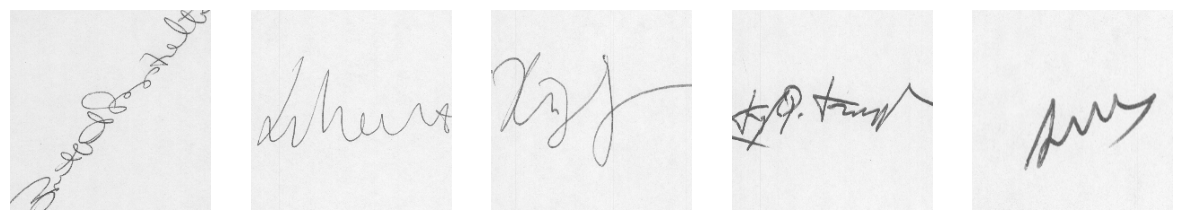

Random Forged Images:


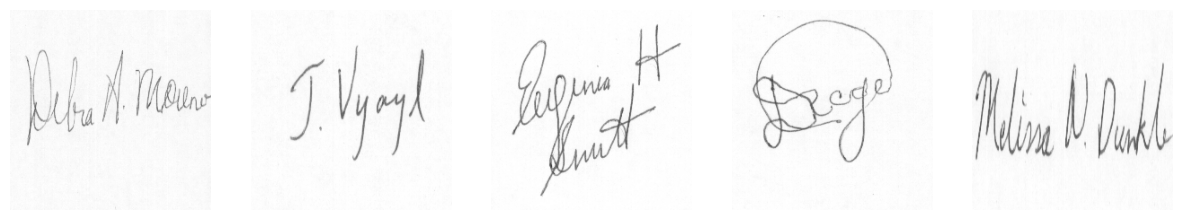

In [8]:
#Some vizualizations

import matplotlib.pyplot as plt
import random

# Assuming org_images and forg_images are lists containing images

# Randomly select 5 indices for original images
random_org_indices = random.sample(range(len(org_images)), 5)

# Randomly select 5 indices for forged images
random_forg_indices = random.sample(range(len(forg_images)), 5)

# Display randomly selected original images
print("Random Original Images:")
plt.figure(figsize=(15, 3))
for i, idx in enumerate(random_org_indices):
    plt.subplot(1, 5, i+1)
    plt.imshow(org_images[idx], cmap='gray')
    plt.axis('off')
plt.show()

# Display randomly selected forged images
print("Random Forged Images:")
plt.figure(figsize=(15, 3))
for i, idx in enumerate(random_forg_indices):
    plt.subplot(1, 5, i+1)
    plt.imshow(forg_images[idx], cmap='gray')
    plt.axis('off')
plt.show()


In [3]:
#Separate training and test data , deleting files we dont use  

# from sklearn.model_selection import train_test_split

# # Split the combined data and labels into train and test sets
# train_images, test_images, train_labels, test_labels = train_test_split(all_images, all_labels, test_size=0.2, random_state=42)

# x_train, x_cv, y_train, y_cv = train_test_split(train_images, train_labels, test_size=0.25, train_size=0.75, random_state=42)



# # Check the sizes of the splits
# print("Train images:", train_images.shape)
# print("Test images:", test_images.shape)
# print("Train labels:", train_labels.shape)
# print("Test labels:", test_labels.shape)


# print(x_train.shape)
# print(x_cv.shape)


import gc
import tensorflow.keras.backend as K

# Delete variables that are no longer needed
# del train_generator,test_generator
del  all_images , all_labels 
# forg_images, forg_labels, org_images, org_labels
# Collect garbage to free up unreferenced memory
# gc.collect()


# Clear Keras session or reset TensorFlow graph
# K.clear_session()

In [4]:
import visualkeras
from tensorflow.keras.models import Model

from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.metrics import confusion_matrix

from tensorflow.keras.applications import VGG16, ResNet50, InceptionV3, MobileNet, Xception ,EfficientNetB0,InceptionResNetV2 ,DenseNet121,VGG19,ResNet50V2,ResNet101V2,EfficientNetB7,EfficientNetV2B0,EfficientNetV2B3,EfficientNetV2S
from tensorflow.keras.applications import MobileNetV2,NASNetMobile,EfficientNetB1 ,ResNet101
# from keras_resnext import ResNeXt50
# from keras.applications import ShuffleNet
# AlexNet ,SqueezeNet ,GoogLeNet
from tensorflow.keras.models import Sequential  
from tensorflow.keras.layers import Flatten, Dense, Dropout,Conv2D,MaxPooling2D,BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report
import csv

from tensorflow.keras.applications import (

    DenseNet169,
    DenseNet201,
    ResNet152,
    NASNetLarge,
    ConvNeXtTiny
)

from tensorflow.keras.applications import (
    MobileNetV3Small,
    MobileNetV3Large,

    EfficientNetB2,
    EfficientNetB3,
    EfficientNetB4,
    EfficientNetB5,
    EfficientNetB6,


)

In [18]:
from tensorflow.keras.utils import plot_model


model_constructors = {
    'VGG19': VGG19,
    # 'VGG16': VGG16,

    # 'ResNet50': ResNet50,
    # 'ResNet50V2': ResNet50V2,
    # 'ResNet101': ResNet101,
    # 'ResNet101V2': ResNet101V2,

    # 'MobileNet': MobileNet,
    # 'MobileNetV2': MobileNetV2,

    # 'Xception': Xception,

    # 'EfficientNetB0': EfficientNetB0,
    # 'EfficientNetB1': EfficientNetB1,
    # 'EfficientNetV2B3': EfficientNetV2B3,
    # 'EfficientNetV2S':EfficientNetV2S,
    # 'EfficientNetB7': EfficientNetB7,
    # 'EfficientNetV2B0':EfficientNetV2B0,
    
    # 'NASNetMobile': NASNetMobile,
    # 'InceptionResNetV2': InceptionResNetV2,
    # 'InceptionV3': InceptionV3,
    # 'DenseNet121': DenseNet121,
    # 'ConvNeXtTiny':ConvNeXtTiny,
    
    # 'DenseNet169':DenseNet169,
    # 'DenseNet201':DenseNet201,
    # 'ResNet152':ResNet152,
    # 'NASNetLarge':NASNetLarge,
    # 'MobileNetV3Small':MobileNetV3Small,
    # 'MobileNetV3Large':MobileNetV3Large,

    # 'EfficientNetB2':EfficientNetB2,
    # 'EfficientNetB3':EfficientNetB3,
    # 'EfficientNetB4':EfficientNetB4,
    # 'EfficientNetB5':EfficientNetB5,
    # 'EfficientNetB6':EfficientNetB6,
}

main_path = "./Test/"
os.makedirs(main_path, exist_ok=True)

# Function to create different pre-trained models
def create_pretrained_model(model_name):
    if model_name not in model_constructors:
        raise ValueError('Invalid model name')

    input_shape = (224, 224, 3)

    # Get the model constructor using the dictionary
    base_model_constructor = model_constructors[model_name]

    # Create the specified model
    base_model = base_model_constructor(weights='imagenet', include_top=False, input_shape=input_shape)

    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(2, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=output)

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])





    return model
    


# Train and evaluate 20 instances of each pre-trained model
for model_name in model_constructors:
   
    print(f"Training {model_name} model")
    
    # Create a new instance of the pre-trained model for each iteration
    model = create_pretrained_model(model_name)
    try:
        plot_model(model, to_file=f"{main_path}{model_name}_model_architecture.png", show_shapes=True, show_layer_names=True)
    except Exception as e:
        print("An error occurred while plotting the model architecture:", e)
    visualkeras.layered_view(model, to_file=f"{main_path}{model_name}_model_layers.png")

    



    early_stopping = EarlyStopping(monitor='val_loss', patience=15)


        
 # Define a ModelCheckpoint callback to save the model weights during training
    checkpoint_filepath = f"{model_name}_checkpoint.h5"
    checkpoint = ModelCheckpoint(checkpoint_filepath, monitor='val_loss', save_best_only=True, mode='min', verbose=1)

    # Other callbacks like EarlyStopping can also be added here
    callbacks = [checkpoint, early_stopping]
 

    history = model.fit(x_train, 
                        y_train,
                         epochs=200, 
                         batch_size=32,
                         callbacks=[early_stopping], 
                         validation_data=(x_cv, y_cv))
    # ... (evaluation and metrics calculations)
    # Prediction
    directory_path = f"{main_path}Models/"
    os.makedirs(directory_path, exist_ok=True)

    file_path = f"{directory_path}{model_name}_model.h5"
    model.save(file_path)
  

    # test_loss, test_accuracy = model.evaluate(test_images, test_labels)
    # print(f"Test Accuracy: {test_accuracy}")


    predictions = model.predict(test_images)

    # Calculate AUC score
    auc_score = roc_auc_score(test_labels, predictions)

    # Calculate sensitivity and specificity
    tn, fp, fn, tp = confusion_matrix(test_labels.argmax(axis=1), predictions.argmax(axis=1)).ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)


    # Confusion Matrix
    conf_matrix = confusion_matrix(test_labels.argmax(axis=1), predictions.argmax(axis=1))


    # Visualize the confusion matrix as a heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
    plt.title(f'Confusion Matrix {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    confusion_directory = f"{main_path}Confusion_matrix/"
    os.makedirs(confusion_directory, exist_ok=True)

    confusion_matrix_image_path = os.path.join(confusion_directory, f'{model_name}_confusion_matrix.png')
    plt.savefig(confusion_matrix_image_path)
    # plt.show()

    # Evaluate the model on test data
    loss, accuracy = model.evaluate(test_images, test_labels)

    # Write metrics including model name to a CSV file
    data = {
        'Model Name': model_name,  # Replace 'Your_Model_Name' with your actual model name
        'Accuracy': accuracy,
        'AUC': auc_score,
        'Sensitivity': sensitivity,
        'Specificity': specificity
    }

    file_path = f'{main_path}evaluations_metrics.csv'


    # Check if the file exists
    if not os.path.isfile(file_path):
        # If the file doesn't exist, create it and write the header
        with open(file_path, 'w', newline='') as csvfile:
            writer = csv.writer(csvfile)
            writer.writerow(['Model Name', 'Accuracy', 'AUC', 'Sensitivity', 'Specificity'])  # Add header row

    # Assuming 'data' and 'conf_matrix' are defined somewhere in your code

    separator_line = '---------------------------------------------'        

    with open(file_path, 'a', newline='') as csvfile:
        writer = csv.writer(csvfile)

        # Write model name and metrics in a single row
        writer.writerow([
        data['Model Name'],
        data['Accuracy'],
        data['AUC'],
        data['Sensitivity'],
        data['Specificity'],
        'Confusion Matrix',
        *conf_matrix[0],  # assuming conf_matrix is a 2D list
        *conf_matrix[1],  # assuming conf_matrix is a 2D list
        # add more lines if needed for each row in conf_matrix
    ])

    def save_training_plots(history, directory, accuracy_plot_name='accuracy_plot.png', loss_plot_name='loss_plot.png'):
        # Print keys in the history object
        print(history.history.keys())

        # Summarize history for accuracy
        plt.plot(history.history['accuracy'])
        plt.plot(history.history['val_accuracy'])
        plt.title(f'Model Accuracy {model_name}')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Test'], loc='upper left')
        
        accuracy_plot_path = os.path.join(directory, accuracy_plot_name)
        plt.savefig(accuracy_plot_path)  # Save the accuracy plot with a custom name and path
        plt.close()

        # Summarize history for loss
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title(f'Model Loss {model_name}')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Test'], loc='upper left')

        loss_plot_path = os.path.join(directory, loss_plot_name)
        plt.savefig(loss_plot_path)  # Save the loss plot with a custom name and path
        plt.close()

    directory_path_plots = f"{main_path}Plots"
    os.makedirs(directory_path_plots, exist_ok=True)
    

    # Example usage:
    save_training_plots(history, directory_path_plots, accuracy_plot_name=f'{model_name}_accuracy_plot.png', loss_plot_name=f'{model_name}_loss_plot.png')


Training VGG19 model
An error occurred while plotting the model architecture: module 'pydot' has no attribute 'InvocationException'
Epoch 1/200
50/50 [==============================] - 12s 229ms/step - loss: 0.9017 - accuracy: 0.6471 - val_loss: 0.4451 - val_accuracy: 0.8239
Epoch 2/200
50/50 [==============================] - 9s 178ms/step - loss: 0.4344 - accuracy: 0.7992 - val_loss: 0.3082 - val_accuracy: 0.9072
Epoch 3/200
50/50 [==============================] - 9s 173ms/step - loss: 0.3123 - accuracy: 0.8718 - val_loss: 0.1809 - val_accuracy: 0.9564
Epoch 4/200
50/50 [==============================] - 9s 179ms/step - loss: 0.2134 - accuracy: 0.9205 - val_loss: 0.1383 - val_accuracy: 0.9716
Epoch 5/200
50/50 [==============================] - 9s 188ms/step - loss: 0.1897 - accuracy: 0.9312 - val_loss: 0.1492 - val_accuracy: 0.9602
Epoch 6/200
50/50 [==============================] - 10s 195ms/step - loss: 0.1344 - accuracy: 0.9470 - val_loss: 0.1086 - val_accuracy: 0.9716
Epoch 7/

/home/aris/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


17/17 [==============================] - 2s 136ms/step - loss: 0.0143 - accuracy: 0.9981
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


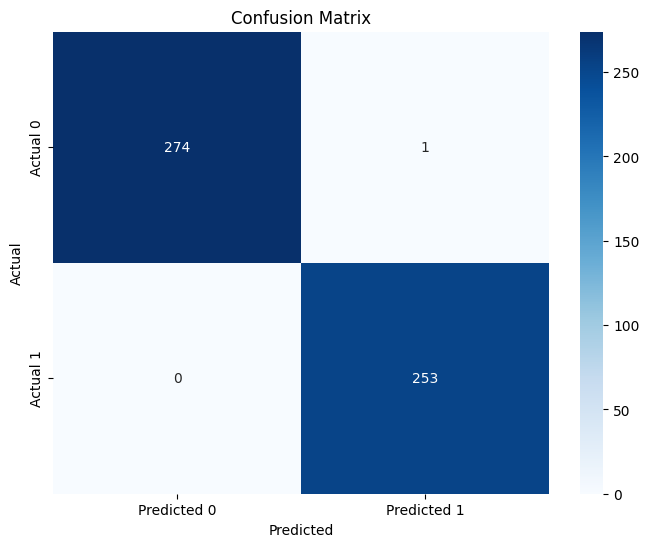

In [12]:
# Visualize the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
confusion_directory = "/home/aris/helloWorld/Test/Confusion_matrix/"
os.makedirs(confusion_directory, exist_ok=True)

confusion_matrix_image_path = os.path.join(confusion_directory, f'{model_name}_confusion_matrix.png')
# plt.savefig(confusion_matrix_image_path)
plt.show()

In [15]:
loaded_model.summary()

NameError: name 'loaded_model' is not defined

In [32]:
model_constructors = {
    # working models for heatmaps
    # 'VGG19': VGG19,
    # 'VGG16': VGG16,
    # 'ResNet50V2': ResNet50V2,
    # 'MobileNet': MobileNet,
    # 'MobileNetV2': MobileNetV2,
    # 'Xception': Xception,
    # 'EfficientNetV2S':EfficientNetV2S,
    # 'NASNetMobile': NASNetMobile,
    # 'InceptionResNetV2': InceptionResNetV2,
    # 'InceptionV3': InceptionV3,
    # 'DenseNet121': DenseNet121,
    # 'DenseNet169':DenseNet169,
    # 'DenseNet201':DenseNet201,    
    # 'NASNetLarge':NASNetLarge,
    # 'ResNet101V2': ResNet101V2,


    # failed to generate heatmpas
    # 'ResNet50': ResNet50,
    # 'ResNet101': ResNet101,

    # 'EfficientNetB0': EfficientNetB0,
    # 'EfficientNetB1': EfficientNetB1,
    # 'EfficientNetV2B3': EfficientNetV2B3,
    # 'EfficientNetB7': EfficientNetB7,
    # 'EfficientNetV2B0':EfficientNetV2B0,
    # 'ConvNeXtTiny':ConvNeXtTiny,
    # 'ResNet152':ResNet152,
    # 'MobileNetV3Small':MobileNetV3Small,
    # 'MobileNetV3Large':MobileNetV3Large,
    # 'EfficientNetB2':EfficientNetB2,
    # 'EfficientNetB3':EfficientNetB3,
    # 'EfficientNetB4':EfficientNetB4,
    # 'EfficientNetB5':EfficientNetB5,
    # 'EfficientNetB6':EfficientNetB6,
}

import tensorflow as tf

for model_name, model_constructor in model_constructors.items():
    print(model_name)
    # Instantiate the model
    # loaded_model = model_constructor()
    x_model = model_name
    loaded_model =tf.keras.models.load_model(f'/home/aris/helloWorld/SignatureForgeryClassification/Saved_Models/{x_model}_model.h5')
    # Print information about the model
    print(f"Model Name: {model_name}")


    def generate_heatmap_overlay(model, x, y, target_size=(224, 224), alpha=0.5):
        # selected_image = cv2.resize(x, target_size)
        selected_image = x
        true_label = y
        selected_image = np.expand_dims(selected_image, axis=0)

        preds = model.predict(selected_image)
        i = np.argmax(preds)

        icam = GradCAM(model, i, None)
        heatmap = icam.compute_heatmap(selected_image)

        print(f"i: {i}, true_label: {true_label}, heatmap shape: {heatmap.shape}")


        # Check if the heatmap is valid
        if heatmap is not None and np.any(heatmap):
            heatmap = cv2.resize(heatmap, target_size)

            image = x
            image = cv2.resize(image, target_size)
            image = (image * 255).astype(np.uint8)

            # Overlay heatmap on the input image
            (heatmap, output) = icam.overlay_heatmap(heatmap, image, alpha=alpha)

            true_class_index = np.argmax(true_label)

            if true_class_index == 1:
                true_class = "Forge"
            else:
                true_class = "Real"

            return output, true_class
        else:
            # print(f"Heatmap generation failed for image {i + 1}")
            return None, None
    

    model_name_v = model_name
    real_count = 0
    forge_count = 0
    desired_count_per_class = 50

    for i in range(len(org_images)):
        true_label = org_labels[i]
        print(true_label)
        # break
        is_real = np.argmax(true_label) == 0  # Assuming 0 is the index for "Real" class

        heatmap_overlay, true_class = generate_heatmap_overlay(loaded_model, org_images[i], true_label, target_size=(224, 224), alpha=0.3)
        
        if heatmap_overlay is not None and true_class is not None:
            # Predict the label
            prediction = loaded_model.predict(np.expand_dims(org_images[i], axis=0))
            predicted_label = np.argmax(prediction)
            
            # Get the true label name and predicted label name
            true_label_name = 'Real' if is_real else 'Forged'
            predicted_label_name = 'Real' if predicted_label == 0 else 'Forged'

            output_directory = f"/home/aris/helloWorld/Test/Heatmaps/Real/{model_name_v}"
            os.makedirs(output_directory, exist_ok=True)

            if is_real and real_count < desired_count_per_class:
                output_path = os.path.join(output_directory, f"True_{true_label_name}_Pred_{predicted_label_name}_{real_count}_heatmap.png")
                cv2.imwrite(output_path, heatmap_overlay)
                print(f"Heatmap overlay saved at {output_path}")
                real_count += 1

        else:
            print(f"Skipping image {i + 1} due to heatmap generation failure")

        # Check if the desired number of images for both classes is reached
        if real_count == desired_count_per_class:
            break

    for i in range(len(forg_images)):
        true_label = forg_labels[i]
        print(true_label)
        # break
        is_real = np.argmax(true_label) == 0  # Assuming 0 is the index for "Real" class

        heatmap_overlay, true_class = generate_heatmap_overlay(loaded_model, forg_images[i], true_label, target_size=(224, 224), alpha=0.3)
        
        if heatmap_overlay is not None and true_class is not None:
            # Predict the label
            prediction = loaded_model.predict(np.expand_dims(forg_images[i], axis=0))
            predicted_label = np.argmax(prediction)
            
            # Get the true label name and predicted label name
            true_label_name = 'Real' if is_real else 'Forged'
            predicted_label_name = 'Real' if predicted_label == 0 else 'Forged'

            output_directory = f"/home/aris/helloWorld/Test/Heatmaps/Forged/{model_name_v}"
            os.makedirs(output_directory, exist_ok=True)

            if  forge_count < desired_count_per_class:
                output_path = os.path.join(output_directory, f"True_{true_label_name}_Pred_{predicted_label_name}_{forge_count}_heatmap.png")
                cv2.imwrite(output_path, heatmap_overlay)
                print(f"Heatmap overlay saved at {output_path}")
                forge_count += 1
        else:
            print(f"Skipping image {i + 1} due to heatmap generation failure")

        # Check if the desired number of images for both classes is reached
        if forge_count == desired_count_per_class:
            break

EfficientNetB5
Model Name: EfficientNetB5
[1. 0.]
1/1 [==============================] - 2s 2s/step
i: 0, true_label: [1. 0.], heatmap shape: (224, 224)
Skipping image 1 due to heatmap generation failure
[1. 0.]
1/1 [==============================] - 0s 67ms/step
i: 0, true_label: [1. 0.], heatmap shape: (224, 224)
Skipping image 2 due to heatmap generation failure
[1. 0.]
1/1 [==============================] - 0s 57ms/step
i: 0, true_label: [1. 0.], heatmap shape: (224, 224)
Skipping image 3 due to heatmap generation failure
[1. 0.]
1/1 [==============================] - 0s 68ms/step
i: 0, true_label: [1. 0.], heatmap shape: (224, 224)
Skipping image 4 due to heatmap generation failure
[1. 0.]
1/1 [==============================] - 0s 65ms/step
i: 0, true_label: [1. 0.], heatmap shape: (224, 224)
Skipping image 5 due to heatmap generation failure
[1. 0.]
1/1 [==============================] - 0s 64ms/step
i: 0, true_label: [1. 0.], heatmap shape: (224, 224)
Skipping image 6 due to hea

KeyboardInterrupt: 